### Machine Learning Audio Classification MEL CNN
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

Important Reads:
* https://arxiv.org/pdf/1807.09902.pdf (dataset paper)


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import helper
import importlib
import h5py
#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)
np.random.seed(42)

# are we resuming training?
resume = False

2.7.0
Num GPUs Available:  1


2022-02-12 17:55:42.462392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:55:42.502634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:55:42.502891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### MEL FEATURE READ IN
In this section we will read in our kaggle 2018 datasets which have already been featured extracted and normalized

In [2]:
# data set root
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# the cached feature extraction data root folder
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load in pre-processed MFCC train data
X_train = np.load( os.path.join(data_npy_folder, "X-mel-train.npy" ) )
y_train = np.load( os.path.join(data_npy_folder, "y-mel-train.npy" ) )

# load in pre-processed MFCC train data
X_test = np.load( os.path.join(data_npy_folder, "X-mel-test.npy" ) )
y_test = np.load( os.path.join(data_npy_folder, "y-mel-test.npy" ) )


In [3]:
# output X_train and X_test shape
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# output y_train and y_test shape
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (9473, 128, 173), X_test shape: (1600, 128, 173)
y_train shape: (9473,), y_test shape: (1600,)


### Visualize the label count distribution for train and test data

<BarContainer object of 41 artists>

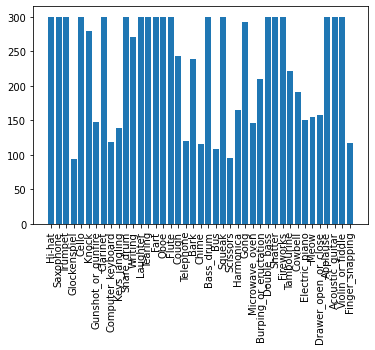

In [4]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

<BarContainer object of 41 artists>

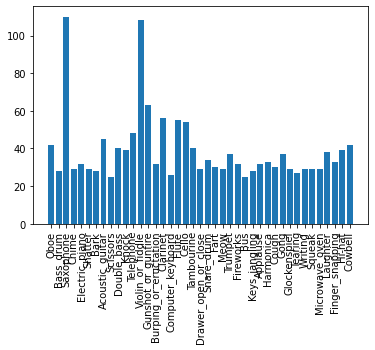

In [5]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

### Encode Labels
In this section we will encode to categorical our y data

In [4]:
# encode the labels to categorical
le = LabelEncoder()

y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.fit_transform(y_test))

In [5]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

y_train[0], y_train_encoded[0], num_labels

('Hi-hat',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 41)

### Reshape Data
In this section we will reshape our X data to be placed into the neural network

In [6]:
n_mfcc = 128 # IDK from orignal data shape I forgot to control n_fft and hop_length
sampling_rate = 44100
audio_duration = 2
audio_length = audio_duration * sampling_rate
input_shape = (n_mfcc, 1 + int(np.floor(audio_length/512)), 1)
input_shape

(128, 173, 1)

In [7]:
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

### Construct the model
In this section we will construct the model

In [12]:
if resume is False: # if we are not resuming from a previous model
    # Regularization rates
    spatial_dropout_rate_1 = 0.07
    spatial_dropout_rate_2 = 0.14
    l2_rate = 0.0005

    # Create a sequential object
    model = Sequential()
    # Conv 1
    model.add(Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=l2(l2_rate), 
                        input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))

2022-02-12 12:55:38.176110: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 12:55:38.178162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 12:55:38.178534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 12:55:38.178795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer
<br>

### Categorical Crossentropy

**categorical_crossentropy:** Used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, is converted into categorical encoding using keras.

In [14]:
# 2. compile the model
if resume is False:
    learing_rate = 1e-4 #0.000001 # 5
    beta_1 = 0.99
    beta_2 = 0.999

    num_epochs = 500 # standard we are training for 500 epochsmodel_path
    num_batch_size = 32 # NOTE: for resnets batch size seems to be the best hyper parameter that improves performance

    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learing_rate, beta_1=beta_1, beta_2=beta_2), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

### visualise the model

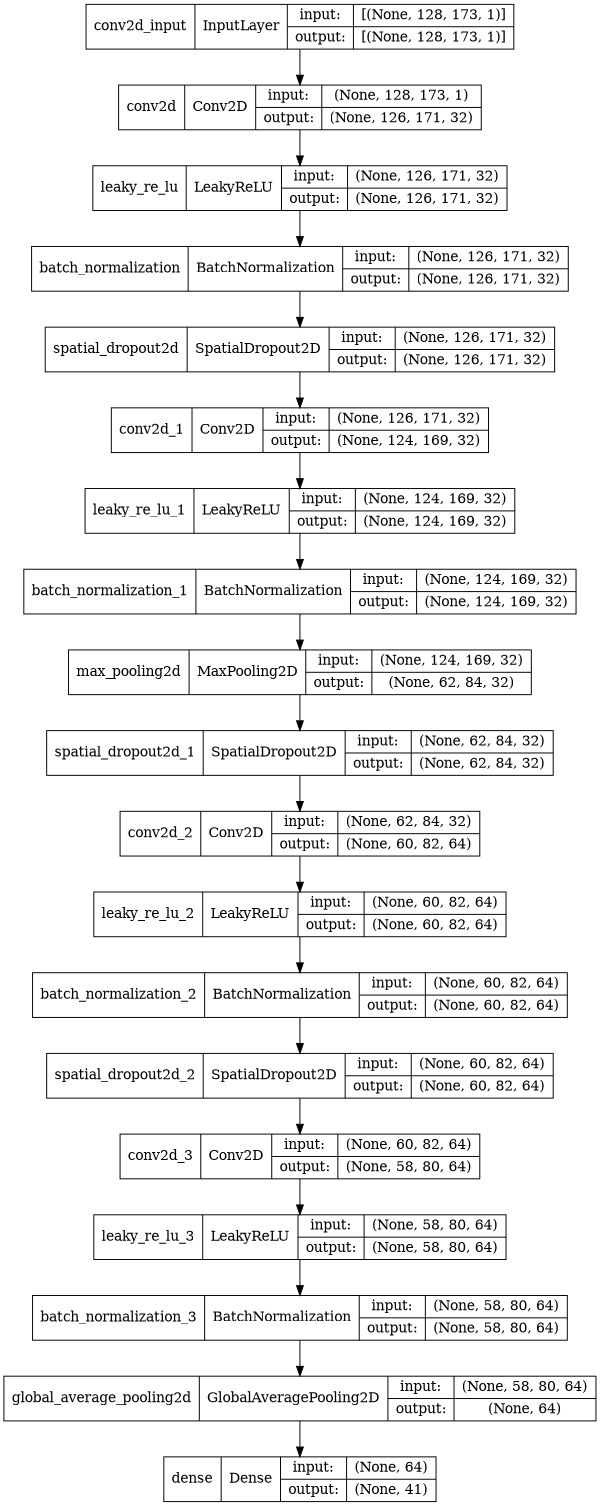

In [15]:

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [16]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')

if resume is False:
    # this is where we will save the model too
    model_path = os.path.join(model_dir, f'MEL_CNN_lr-{learing_rate}_b1-{beta_1}_b2-{beta_2}_EPOCH-{num_epochs}_BATCH-{num_batch_size}_cc_v3.h5')
else:
    num_epochs = 500
    num_batch_size = 32 # recommend keeping same as saved model
    print("Resuming training...")
    model_path = os.path.join(model_dir, 'MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v3.h5')
    # Load best saved model
    print("Loading best saved model...")
    model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v3.h5'

In [17]:
# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    validation_data=(X_test, y_test_encoded),
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    #validation_split=1/12.,
    callbacks=[checkpointer, early_stopping_callback], 
    verbose=1
)

end = datetime.now() - start
print("Training time: {}".format(end))

Epoch 1/500


2022-02-12 12:56:44.190915: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


297/297 [==============================] - ETA: 0s - loss: 3.6058 - accuracy: 0.0828
Epoch 00001: val_loss improved from inf to 3.82850, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v3.h5
297/297 [==============================] - 21s 63ms/step - loss: 3.6058 - accuracy: 0.0828 - val_loss: 3.8285 - val_accuracy: 0.0419
Epoch 2/500
296/297 [============================>.] - ETA: 0s - loss: 3.3768 - accuracy: 0.1286
Epoch 00002: val_loss improved from 3.82850 to 3.39966, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v3.h5
297/297 [==============================] - 18s 61ms/step - loss: 3.3768 - accuracy: 0.1286 - val_loss: 3.3997 - val_accuracy: 0.0906
Epoch 3/500
296/297 [============================>.] - ETA: 0s - loss: 3.2394 - accuracy: 0.1535
Epoch 00003: val_loss improved from 3.39966 to 3.12580, saving model to /

Text(0.5, 0, 'epochs')

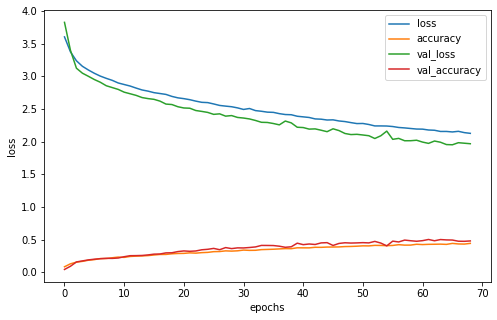

In [18]:
# plot history also known as loss curve 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [19]:

model.metrics_names

['loss', 'accuracy']

In [8]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')
#model_path = os.path.join(model_dir, "V3/RESNET")
model_path = os.path.join(model_dir, f'MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v3.h5')

model = load_model(model_path)

2022-02-12 17:57:02.391461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-12 17:57:02.393337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:57:02.393766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 17:57:02.394100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [9]:
importlib.reload(helper)
helper.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

2022-02-12 17:57:05.506261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 839080448 exceeds 10% of free system memory.
2022-02-12 17:57:05.992663: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 839080448 exceeds 10% of free system memory.
2022-02-12 17:57:07.091051: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


50/50 [==============================] - 1s 18ms/step - loss: 1.9524 - accuracy: 0.4925
                    LOSS      ACCURACY
--------------------------------------
Training:         1.9986       48.4852
Test:             1.9524       49.2500
Normal diff          2.31 


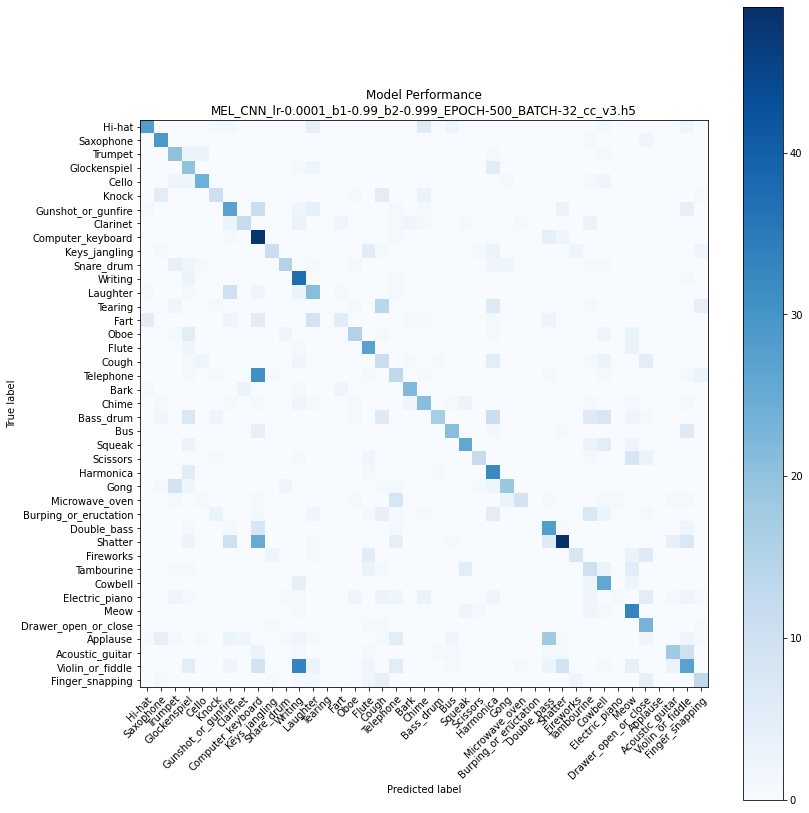

In [11]:

importlib.reload(helper)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helper.plot_confusion_matrix(
    cm=cm,
    classes=train_metadata['label'].unique(),
    normalized=False, 
    title=f"Model Performance\n{model_path.split('/')[-1]}", 
    cmap=plt.cm.Blues,
    size=(12,12))

### Custom H5PY format
This section will append the label information into the h5 model so that our interface program can easily load these models

In [12]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')
#model_path = os.path.join(model_dir, "V3/RESNET")
model_path = os.path.join(model_dir, f'MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v3.h5')


In [13]:
importlib.reload(helper)
model, metadata = helper.load_model_ext(model_path)
model, metadata

(<keras.engine.sequential.Sequential at 0x7f2d4352e700>, None)

In [14]:
import json
lables_properly = train_metadata['label'].unique()
labels_json = json.dumps(list(lables_properly))
labels_json

'["Hi-hat", "Saxophone", "Trumpet", "Glockenspiel", "Cello", "Knock", "Gunshot_or_gunfire", "Clarinet", "Computer_keyboard", "Keys_jangling", "Snare_drum", "Writing", "Laughter", "Tearing", "Fart", "Oboe", "Flute", "Cough", "Telephone", "Bark", "Chime", "Bass_drum", "Bus", "Squeak", "Scissors", "Harmonica", "Gong", "Microwave_oven", "Burping_or_eructation", "Double_bass", "Shatter", "Fireworks", "Tambourine", "Cowbell", "Electric_piano", "Meow", "Drawer_open_or_close", "Applause", "Acoustic_guitar", "Violin_or_fiddle", "Finger_snapping"]'

In [15]:
helper.save_model_ext(model, model_path, overwrite=True, meta_data=labels_json)